# Fitting a Forward Model (Saturation & Concentration Based)
Can we find a forward ML model that can essentially do the simulations for us given the TMPs?

The ultimate goal is to use this forward model as a loss function in inverse modelling. This gives us 2 benefits.
1. Adds an additional loss term to the current inverse model training. This should improve **validation loss/overfitting issues** while making training even better. It can be thought of as a feedback loop.
2. During actual experimentation, we can keep an internal state between different timeframes. A forward model will allow us to generate predictions from this internal state. The goal would be to tie in value consistency within the prediction system. (Think of a Kalman Filter/RNN)

# Things to Try
## 1. Learning the curve-fitting parameters
Curve fitting paramters hold enough information about the entire spatial intensity curve, given the fit is actually good. The hope is that it should be easier for a model to learn 3 x 2 fitting parameters compared to 40 spatial intensity outputs. 

This actually works pretty well. Here are some results
    Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=6, bias=True)
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=8, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 0.9
...
            Validation Method: Holds out fMaternal Wall Thickness columns 0.2182178902359924 for validation. The rest are used for training
        Loss:
            Train Loss: 0.005227597474215039
            Val. Loss: 0.03782471343874931


(PS: The loss is calclated as the MSE over all 6 output parameters, fitting done with weights 1.0, 0.8)

This does not work. The model does learn the curve-fitting paramters pretty well. however, the way those pramters are defined, even a small change actually impacts the output greatly. So, the error curve-fitting domain might not be large but in Spatial intensity doman, the curves are usually absurd. Usually rising exponential curves. This method **DOES NOT** work.

## 2. Learning SI itself(20 pts)


In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp, get_interpolate_fit_params
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity, create_curve_fitting_param
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Get Interpolation parameters
# data = create_curve_fitting_param(data, (1.0, 0.8))
data = create_spatial_intensity(data)

# Cleanup
data.dropna(inplace=True)
data.head() 

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,0.000016,0.000001,2.718709e-07,9.464432e-08,3.839152e-08,...,3.363500e-12,1.737803e-12,9.597128e-13,5.314507e-13,2.898699e-13,1.607546e-13,8.137145e-14,4.898833e-14,3.144881e-14,1.494469e-14
1,2.0,12.0,0.9,0.11,0.225,0.000016,0.000001,2.786322e-07,9.831888e-08,4.037762e-08,...,3.187247e-12,1.635889e-12,8.985087e-13,4.934708e-13,2.676614e-13,1.475725e-13,7.411840e-14,4.439671e-14,2.849481e-14,1.341202e-14
2,2.0,12.0,0.9,0.11,0.350,0.000016,0.000001,2.860341e-07,1.024130e-07,4.263190e-08,...,3.024762e-12,1.542662e-12,8.428767e-13,4.591845e-13,2.477394e-13,1.358392e-13,6.772203e-14,4.035975e-14,2.589890e-14,1.207807e-14
3,2.0,12.0,0.9,0.11,0.475,0.000016,0.000001,2.941981e-07,1.070160e-07,4.521856e-08,...,2.874741e-12,1.457243e-12,7.922208e-13,4.281774e-13,2.298334e-13,1.253740e-13,6.206850e-14,3.680237e-14,2.361207e-14,1.091422e-14
4,2.0,12.0,0.9,0.11,0.600,0.000016,0.000001,3.032841e-07,1.122485e-07,4.822589e-08,...,2.736025e-12,1.378852e-12,7.460177e-13,4.000876e-13,2.137088e-13,1.160212e-13,5.706067e-14,3.366071e-14,2.159274e-14,9.896389e-15


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [4]:
## Y -> Target
# y_columns = list(filter(lambda X: 'alpha' in X, data.columns))
y_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))

## X -> Predictors
x_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration', "Maternal Saturation", 
             "Fetal Hb Concentration", "Fetal Saturation"]


# Log first -> this gives almost equal emphasis on the far detectors
data[y_columns] = np.log10(data[y_columns])


## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [5]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
count,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,0.000000,2.842171e-17,1.215028e-15,-1.286082e-16,-1.953104e-16,-4.274625e-15,-9.094947e-16,6.821210e-16,-4.547474e-17,4.547474e-16,...,1.818989e-16,3.637979e-16,9.094947e-17,-3.637979e-16,-1.818989e-16,-9.094947e-17,2.728484e-16,-1.818989e-16,1.818989e-16,3.637979e-16
std,1.000100,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,...,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.527525,-1.414214e+00,-1.414214e+00,-1.414214e+00,-1.414214e+00,-1.624460e+00,-1.129634e+00,-1.143370e+00,-1.235018e+00,-1.416570e+00,...,-2.211389e+00,-2.104478e+00,-2.069320e+00,-2.253893e+00,-2.016820e+00,-2.217398e+00,-2.353822e+00,-2.173785e+00,-2.219628e+00,-2.047743e+00
25%,-0.763763,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-6.873661e-01,-6.186487e-01,-6.423822e-01,-7.271412e-01,-8.061505e-01,...,-7.239912e-01,-7.780518e-01,-8.144708e-01,-7.521559e-01,-8.357454e-01,-7.456425e-01,-7.059747e-01,-8.192119e-01,-7.521019e-01,-8.578142e-01
50%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-3.140185e-16,-6.107400e-02,-2.827072e-01,-3.845987e-01,-4.277251e-01,-3.618888e-01,...,7.129379e-02,1.308484e-01,1.031200e-01,1.896935e-01,4.451840e-02,1.182704e-01,1.029087e-01,1.468204e-01,1.593516e-01,1.084204e-01
75%,0.763763,7.071068e-01,7.071068e-01,7.071068e-01,7.071068e-01,5.129325e-01,1.210669e-01,3.112115e-01,6.612538e-01,8.354610e-01,...,8.477818e-01,8.417689e-01,8.568146e-01,8.209879e-01,8.877437e-01,8.237295e-01,8.666606e-01,8.744803e-01,8.582802e-01,9.309421e-01
max,1.527525,1.414214e+00,1.414214e+00,1.414214e+00,1.414214e+00,3.549921e+00,3.007895e+00,2.529494e+00,2.213074e+00,1.969517e+00,...,1.483255e+00,1.465787e+00,1.477751e+00,1.385228e+00,1.525376e+00,1.468292e+00,1.439329e+00,1.437057e+00,1.413710e+00,1.442076e+00


## Model Configuration

In [6]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    # Standard Scaling w.r.t. Maternal Wall thickness : The original values are gone. Hold one out for some value
    # in the middle of the pack
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data["Maternal Wall Thickness"].unique()[4])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 4, 8, 16, OUT_FEATURES], 'dropout_rates': [0.01, 0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [7]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [8]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-2),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [9]:
# best_trial.config

## Custom Training

In [10]:
set_seed(42)
trainer = trainer_factory.create()
# trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 4e-3, 'momentum': 0.90})
trainer.epochs = 100
trainer.run()

In [11]:
# trainer.epochs = 50
# trainer.run()

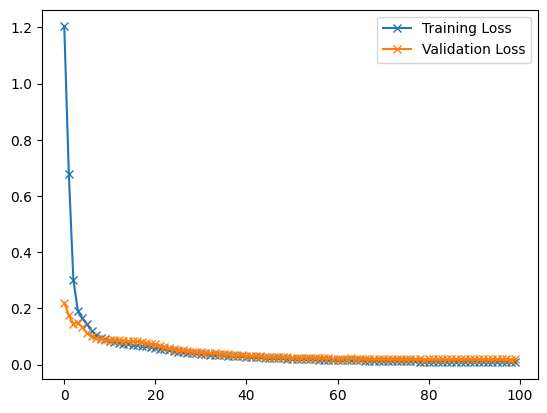

In [12]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [16]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.01, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=40, bias=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.004
    maximize: False
    momentum: 0.9
    nesterov: False
    wei

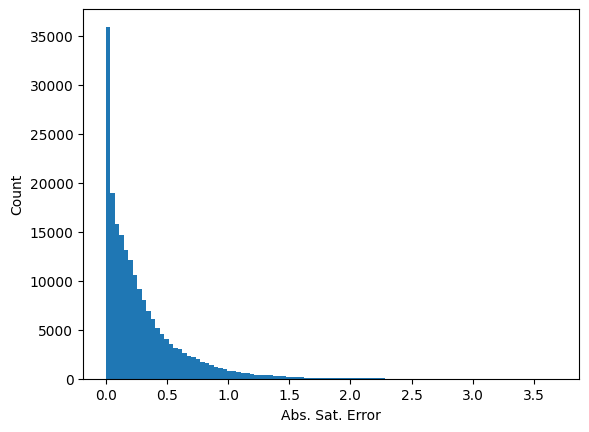

In [14]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    # predictions = fwd_model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
# error_df['%tage'].plot.hist(bins=100)
error_df['Absolute Error'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Abs. Sat. Error')
plt.ylabel('Count')
plt.show()

In [17]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [7.51400132e-05 1.58474219e-03 8.75411011e-03 2.24128794e-02
 4.36221610e-02 6.69179877e-02 9.90115869e-02 1.08219453e-01
 1.21283839e-01 1.17519895e-01 1.14835570e-01 1.12607298e-01
 1.39095102e-01 1.20481928e-01 1.25588742e-01 1.46344896e-01
 1.26484004e-01 1.56007785e-01 1.62347782e-01 1.35374024e-01
 2.67305395e-05 4.04269329e-04 8.18770893e-03 3.09228269e-02
 8.61249374e-02 1.49191841e-01 2.47782931e-01 2.93780593e-01
 3.36031237e-01 3.67810214e-01 3.49293931e-01 3.90240844e-01
 3.77202094e-01 4.92209012e-01 3.61594050e-01 3.93864453e-01
 4.32489383e-01 4.67791036e-01 4.88475274e-01 5.09645176e-01]
Validation Error(non-normalized): [1.86518431e-04 3.93377127e-03 2.17301383e-02 5.56350061e-02
 1.08282347e-01 1.66109075e-01 2.45774322e-01 2.68630810e-01
 3.01060252e-01 2.91717095e-01 2.85053854e-01 2.79522661e-01
 3.45272765e-01 2.99069686e-01 3.11746219e-01 3.63268772e-01
 3.13968509e-01 3.87254752e-01 4.02992389e-01 3.36036014e-01
 6.63526404e-05 1.003

In [ ]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       48
│    └─BatchNorm1d: 2-2                  16
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       108
│    └─BatchNorm1d: 2-6                  24
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       208
│    └─BatchNorm1d: 2-10                 32
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      680
│    └─Flatten: 2-14                     --
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0

In [18]:
model_name = 'forward_curve_fit_paramv2'
import joblib
# Save Model
torch.save(trainer.model.state_dict(), rf'../models/{model_name}')
# Save the Scalers for Later Use
joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

['../models/forward_curve_fit_paramv2_yscaler']

In [ ]:
# # Load Model Code
# import joblib
# model_name = 'forward_curve_fit_paramv1'
# fwd_model = PerceptronBD([5, 6, 8, 8], dropout_rates = [0.2, 0.2])
# fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
# fwd_model = fwd_model.cuda()
# fwd_model = fwd_model.eval()
# # The input TMPs will already be scaled. No need to further use an x_scaler
# y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
# x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')